# **Task 2**

Turgunboev Dadakhon


In this project, I processed a set of images using the **DenseNet201** pre-trained neural network for feature extraction. After extracting the features, I scaled them, reduced their dimensionality using **PCA** (Principal Component Analysis), and performed clustering with the **K-Means algorithm**. Finally, I **visualized** the clustering results using both 2D and 3D plots to better understand the distribution of clusters.

The main goal of this work was to group the images into several clusters based on their features and present the clustering results using meaningful visualizations.

## DataLoading&preprocessing



---




*   **Resize**: All images were resized to
224
×
224
224×224 pixels, the standard input size for the pre-trained model.
*   **ToTensor**: The images were converted to tensors, making them suitable for input into PyTorch models.
*   **Normalization**: The images were normalized using the mean and standard deviation values that were used during the training of the pre-trained model on **ImageNet**.



The data was loaded using a DataLoader, which efficiently processes the images in batches of 32, ensuring randomness and helping with model generalization during training.


---



In [6]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import numpy as np
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from torchvision import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd


transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.Flowers102(root='data', split='train', download=True, transform=transform)

dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

##Feature Extraction
To extract features from the images, I used the **DenseNet201** model, which was pre-trained on a large dataset. By using the pre-trained weights, I was able to extract high-level features from the images without the need to train the model from scratch. The feature extraction was done by *excluding the final classification layer of the model*.

While **DenseNet201** introduces improvements in terms of model depth and efficiency compared to earlier versions, *I did not notice significant differences in performance or results for this particular project*

*   I loaded the **DenseNet201** model and removed the last classification layer.
*   The extracted features were flattened into one-dimensional vectors for further processing.



In [8]:
model = models.densenet201(pretrained=True)
model_features = nn.Sequential(*list(model.features.children())[:-1])

E:\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
def extract_features(dataloader, model):
    features = []
    labels = []

    with torch.no_grad():
        for images, label in dataloader:
            output = model(images)
            feature_vector = output.view(output.size(0), -1)
            features.append(feature_vector)
            labels.extend(label.numpy())

    features = torch.cat(features, dim=0)
    return features.numpy(), labels

features, labels = extract_features(dataloader, model)

**Feature Scaling**

For feature scaling, I experimented with three different scalers: **RobustScaler**, **StandardScaler**, and **MinMaxScaler**

**RobustScaler**: This scaler performed well in this context, as it is less sensitive to outliers and ensures that the features are centered and scaled while maintaining robustness. It produced a good spread of the data and allowed the clustering algorithm to perform effectively.

**StandardScaler**: This scaler also provided good results, standardizing the features to have zero mean and unit variance. The clustering results were similar to those with the **RobustScaler**, and the scaling seemed to work well for the **K-Means algorithm**.

**MinMaxScaler**: While the **MinMaxScaler** scaled the data to a range of [0, 1], the scaled features appeared too compressed on the graph. The points were clustered too closely together, which made the clusters less distinguishable visually.

In [11]:
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features)

**Dimensionality Reduction with PCA**

To reduce the dimensionality of the feature space and improve computational efficiency, I applied **PCA (Principal Component Analysis)**. PCA allows for the compression of the features while retaining as much of the important information as possible. I reduced the feature space to **100-30** **components.**

Interestingly, I did not observe significant changes in the results between the range of 30 to 100 components. This suggests that the majority of the relevant variance in the data was captured by the first few components. Increasing the number of components beyond a certain threshold (in this case, around 30) did not substantially alter the clustering or the overall distribution of the data.

In [13]:
pca = PCA(n_components=100)
features_pca = pca.fit_transform(features_scaled)
print(f"Shape after PCA: {features_pca.shape}")

Shape after PCA: (1020, 100)


## **Clustering with K-Means**
**Elbow Method for K-Means**: In the Elbow Method, I computed the WCSS (Within-Cluster Sum of Squares) for different values of
𝑘
k (the number of clusters). The WCSS measures the sum of squared distances between each point and the centroid of its assigned cluster.

From the plot, I observed that after three clusters, the reduction in WCSS became marginal, indicating that adding more clusters didn't significantly improve the clustering. Thus, I chose **3** clusters as the optimal number for this dataset.

In [15]:
wcss = []
for k in range(1, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)  
    wcss.append(kmeans.inertia_)

# Plot the WCSS for each k
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', color='b', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

E:\anaconda\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
E:\anaconda\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
E:\anaconda\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
E:\anaconda\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with M

In [16]:
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(features_pca)

E:\anaconda\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


**2D Visualization of Clusters**

To better understand the distribution of the clusters, I performed a 2D visualization by reducing the dimensionality further to 2 components using PCA. The results of the clustering were then visualized using **Matplotlib**.


*   The points on the plot represent the images, and the color of each point corresponds to the cluster it belongs to.
*   The centers of the clusters are marked with red **"X"** symbols.



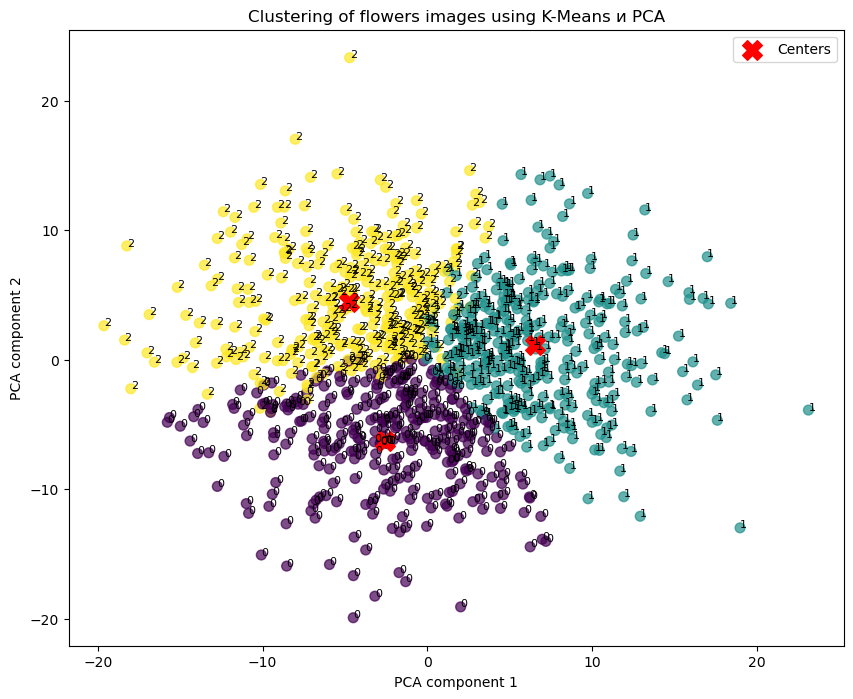

In [18]:
pca_2d = PCA(n_components=2)
features_pca_2d = pca_2d.fit_transform(features_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(features_pca_2d[:, 0], features_pca_2d[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Clustering of flowers images using K-Means и PCA')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centers')
plt.legend()

for i, label in enumerate(labels):
    plt.text(features_pca_2d[i, 0], features_pca_2d[i, 1], str(label), fontsize=8)

plt.show()

**3D Visualization of Clusters**

For a more detailed analysis of the clusters, I created a **3D** visualization using the **Plotly library**. This interactive plot allows for exploring the distribution of clusters in the three-dimensional feature space.

In [20]:
import plotly.express as px

pca = PCA(n_components=3)
features_pca_3d = pca.fit_transform(features_scaled)


df = pd.DataFrame(features_pca_3d, columns=["PCA 1", "PCA 2", "PCA 3"])
df['Cluster'] = labels

fig = px.scatter_3d(df, x='PCA 1', y='PCA 2', z='PCA 3', color='Cluster', title='3D Clustering Visualization')
fig.show()

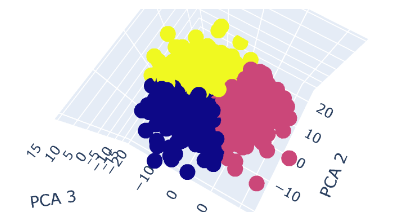

**Conclusion**

In this project, I applied **K-Means clustering** to group a set of images based on features extracted using the **DenseNet201** model and reduced in dimensionality using **PCA**. After evaluating different scaling techniques and performing dimensionality reduction, I used the **Elbow Method** to determine the optimal number of clusters and found that three clusters seemed most appropriate.

However, the clustering results were somewhat limited by the nature of the dataset. *The images contained many similar colors and subtle variations, which made it challenging for the K-Means algorithm to effectively distinguish between the different groups*. As a result, the clustering did not always produce clear separations, and the visualizations showed overlapping clusters, particularly when examining them in 2D and 3D.

Given the challenges of clustering based on color similarity, other clustering algorithms might have been more appropriate. For example, **DBSCAN** **(Density-Based Spatial Clustering of Applications with Noise**) could have performed better, as it doesn't require specifying the number of clusters beforehand and can handle noise and outliers more effectively. Additionally, **Gaussian Mixture Models (GMM)** could have been a suitable alternative, as it allows for more flexibility in the shape of the clusters.

In conclusion, while **K-Means** clustering provided useful insights into the dataset, the similarity in color across images made it difficult for the algorithm to achieve perfect separation. Exploring other clustering techniques or incorporating additional features beyond color could improve the results further.